# Poem Generator With Recurrent Neural Network



In [1]:
artist_file = "_final_poem_ml_scrap.txt"
f = open(artist_file,'r')
print(f.read(1000))

Over hill over dale
Thorough bush thorough brier
Over park over pale
Thorough flood thorough fire
I do wander everywhere
Swifter than the moons sphere
And I serve the Fairy Queen
To dew her orbs upon the green
The cowslips tall her pensioners be
In their gold coats spots you see
Those be rubies fairy favours
In those freckles live their savours
I must go seek some dewdrops here
And hang a pearl in every cowslips ear
FROM off a hill whose concave womb reworded
A plaintful story from a sistering vale
My spirits to attend this double voice accorded
And down I laid to list the sadtuned tale
Ere long espied a fickle maid full pale
Tearing of papers breaking rings atwain
Storming her world with sorrows wind and rain
Upon her head a platted hive of straw
Which fortified her visage from the sun
Whereon the thought might think sometime it saw
The carcass of beauty spent and done
Time had not scythed all that youth begun
Nor youth all quit but spite of heavens fell rage
Some beauty peepd through

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
def plotWordFrequency(input):
    f = open(artist_file,'r')
    words = [x for y in [l.split() for l in f.readlines()] for x in y]
    data = sorted([(w, words.count(w)) for w in set(words)], key = lambda x:x[1], reverse=True)[:40] 
    most_words = [x[0] for x in data]
    times_used = [int(x[1]) for x in data]
    plt.figure(figsize=(20,10))
    plt.bar(x=sorted(most_words), height=times_used, color = 'grey', edgecolor = 'black',  width=.5)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(rotation=0, fontsize=18)
    plt.xlabel('Most Common Words:', fontsize=18)
    plt.ylabel('Number of Occurences:', fontsize=18)
    plt.title('Most Commonly Used Words: %s' % (artist_file), fontsize=24)
    plt.show()


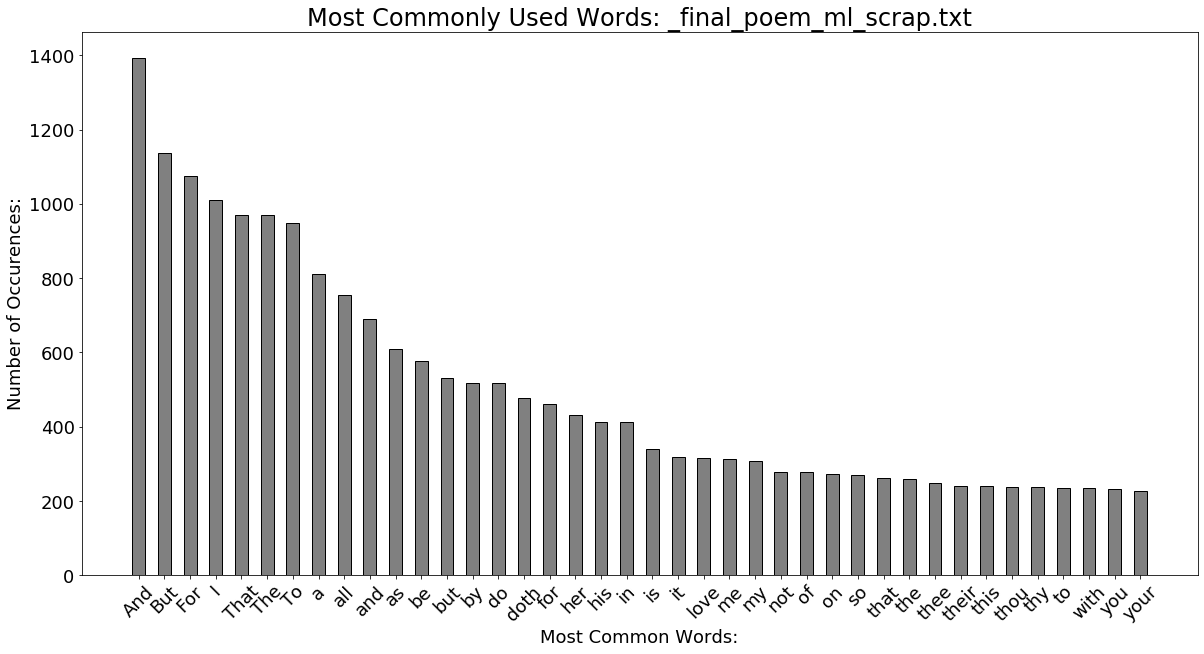

In [3]:
plotWordFrequency(artist_file)

In [4]:
import pronouncing
import markovify
import re
import randomimport numpy as np
import os
import keras
from keras.models import Sequential
from keras.layers import LSTM 
from keras.layers.core import Dense

Using TensorFlow backend.


In [5]:
def create_network(depth):
	model = Sequential()
	model.add(LSTM(4, input_shape=(2, 2), return_sequences=True))
	for i in range(depth):
		model.add(LSTM(8, return_sequences=True))
	model.add(LSTM(2, return_sequences=True))
	model.summary()
	model.compile(optimizer='rmsprop',
              loss='mse')
	if artist + ".rap" in os.listdir(".") and train_mode == False:
		model.load_weights(str(artist + ".rap"))
		print("loading saved network: " + str(artist) + ".rap") 
	return model

In [6]:
def markov(text_file):
    ######
	read = open(text_file, "r", encoding='utf-8').read()
	text_model = markovify.NewlineText(read)
	return text_model

In [7]:
def syllables(line):
	count = 0
	for word in line.split(" "):
		vowels = 'aeiouy'
		word = word.lower().strip(".:;?!")
		if word[0] in vowels:
			count +=1
		for index in range(1,len(word)):
			if word[index] in vowels and word[index-1] not in vowels:
				count +=1
		if word.endswith('e'):
			count -= 1
		if word.endswith('le'):
			count+=1
		if count == 0:
			count +=1
	return count / maxsyllables

In [8]:
def rhymeindex(lyrics):
	if str(artist) + ".rhymes" in os.listdir(".") and train_mode == False:
		print ("loading saved rhymes from " + str(artist) + ".rhymes")
		return open(str(artist) + ".rhymes", "r",encoding='utf-8').read().split("\n")
	else:
		rhyme_master_list = []
		print ("Building list of rhymes:")
		for i in lyrics:
			word = re.sub(r"\W+", '', i.split(" ")[-1]).lower()
			rhymeslist = pronouncing.rhymes(word)
			rhymeslistends = []      
			for i in rhymeslist:
				rhymeslistends.append(i[-2:])
			try:
				rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
			except Exception:
				rhymescheme = word[-2:]
			rhyme_master_list.append(rhymescheme)
		rhyme_master_list = list(set(rhyme_master_list))
		reverselist = [x[::-1] for x in rhyme_master_list]
		reverselist = sorted(reverselist)
		rhymelist = [x[::-1] for x in reverselist]
		print("List of Sorted 2-Letter Rhyme Ends:")
		print(rhymelist)
		f = open(str(artist) + ".rhymes", "w", encoding='utf-8')
		f.write("\n".join(rhymelist))
		f.close()
		return rhymelist

In [9]:
def rhyme(line, rhyme_list):
	word = re.sub(r"\W+", '', line.split(" ")[-1]).lower()
	rhymeslist = pronouncing.rhymes(word)
	rhymeslistends = []
	for i in rhymeslist:
		rhymeslistends.append(i[-2:])
	try:
		rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
	except Exception:
		rhymescheme = word[-2:]
	try:
		float_rhyme = rhyme_list.index(rhymescheme)
		float_rhyme = float_rhyme / float(len(rhyme_list))
		return float_rhyme
	except Exception:
		float_rhyme = None
		return float_rhyme

In [10]:
def split_lyrics_file(text_file):
	text = open(text_file, encoding='utf-8').read()
	text = text.split("\n")
	while "" in text:
		text.remove("")
	return text

In [11]:
def generate_lyrics(text_model, text_file):
	bars = []
	last_words = []
	lyriclength = len(open(text_file,encoding='utf-8').read().split("\n"))
	count = 0
	markov_model = markov(text_file)
	
	while len(bars) < lyriclength / 9 and count < lyriclength * 2:
		bar = markov_model.make_sentence(max_overlap_ratio = .49, tries=100)
		if type(bar) != type(None) and syllables(bar) < 1:
			def get_last_word(bar):
				last_word = bar.split(" ")[-1]
				if last_word[-1] in "!.?,":
					last_word = last_word[:-1]
				return last_word
			last_word = get_last_word(bar)
			if bar not in bars and last_words.count(last_word) < 3:
				bars.append(bar)
				last_words.append(last_word)
				count += 1
	return bars

In [12]:
def build_dataset(lines, rhyme_list):
	dataset = []
	line_list = []
	for line in lines:
		line_list = [line, syllables(line), rhyme(line, rhyme_list)]
		dataset.append(line_list)
	x_data = []
	y_data = []
	for i in range(len(dataset) - 3):
		line1 = dataset[i    ][1:]
		line2 = dataset[i + 1][1:]
		line3 = dataset[i + 2][1:]
		line4 = dataset[i + 3][1:]
		x = [line1[0], line1[1], line2[0], line2[1]]
		x = np.array(x)
		x = x.reshape(2,2)
		x_data.append(x)
		y = [line3[0], line3[1], line4[0], line4[1]]
		y = np.array(y)
		y = y.reshape(2,2)
		y_data.append(y)
	x_data = np.array(x_data)
	y_data = np.array(y_data)
	return x_data, y_data

In [13]:
def compose_rap(lines, rhyme_list, lyrics_file, model):
	rap_vectors = []
	human_lyrics = split_lyrics_file(lyrics_file)
	initial_index = random.choice(range(len(human_lyrics) - 1))
	initial_lines = human_lyrics[initial_index:initial_index + 2]
	starting_input = []
	for line in initial_lines:
		starting_input.append([syllables(line), rhyme(line, rhyme_list)])
	starting_vectors = model.predict(np.array([starting_input]).flatten().reshape(1, 2, 2))
	rap_vectors.append(starting_vectors)
	for i in range(100):
		rap_vectors.append(model.predict(np.array([rap_vectors[-1]]).flatten().reshape(1, 2, 2)))
	return rap_vectors

In [14]:
def vectors_into_song(vectors, generated_lyrics, rhyme_list):
	print ("\n\n")	
	print ("Writing verse:")
	print ("\n\n")
	def last_word_compare(rap, line2):
		penalty = 0 
		for line1 in rap:
			word1 = line1.split(" ")[-1]
			word2 = line2.split(" ")[-1]
			while word1[-1] in "?!,. ":
				word1 = word1[:-1]
			while word2[-1] in "?!,. ":
				word2 = word2[:-1]
			if word1 == word2:
				penalty += 0.2
		return penalty
	def calculate_score(vector_half, syllables, rhyme, penalty):
		desired_syllables = vector_half[0]
		desired_rhyme = vector_half[1]
		desired_syllables = desired_syllables * maxsyllables
		desired_rhyme = desired_rhyme * len(rhyme_list)
		score = 1.0 - abs(float(desired_syllables) - float(syllables)) + abs(float(desired_rhyme) - float(rhyme)) - penalty
		return score
	dataset = []
	for line in generated_lyrics:
		line_list = [line, syllables(line), rhyme(line, rhyme_list)]
		dataset.append(line_list)
	rap = []
	vector_halves = []
	for vector in vectors:
		vector_halves.append(list(vector[0][0])) 
		vector_halves.append(list(vector[0][1]))
	for vector in vector_halves:
		scorelist = []
		for item in dataset:
			line = item[0]
			if len(rap) != 0:
				penalty = last_word_compare(rap, line)
			else:
				penalty = 0
			total_score = calculate_score(vector, item[1], item[2], penalty)
			score_entry = [line, total_score]
			scorelist.append(score_entry)
		fixed_score_list = [0]
		for score in scorelist:
			fixed_score_list.append(float(score[1]))
		max_score = max(fixed_score_list)
		for item in scorelist:
			if item[1] == max_score:
				rap.append(item[0])
				print (str(item[0]))
				for i in dataset:
					if item[0] == i[0]:
						dataset.remove(i)
						break
				break     
	return rap

In [15]:
def train(x_data, y_data, model):
	model.fit(np.array(x_data), np.array(y_data),
			  batch_size=2,
			  epochs=5,
			  verbose=1)
	model.save_weights(artist + ".rap")

In [16]:
def main(depth, train_mode):
	model = create_network(depth)
	text_model = markov(text_file)
	if train_mode == True:
		bars = split_lyrics_file(text_file)
	if train_mode == False:
		bars = generate_lyrics(text_model, text_file)
	rhyme_list = rhymeindex(bars)
	if train_mode == True:
		x_data, y_data = build_dataset(bars, rhyme_list)
		train(x_data, y_data, model)
	if train_mode == False:
		vectors = compose_rap(bars, rhyme_list, text_file, model)
		rap = vectors_into_song(vectors, bars, rhyme_list)
		f = open(rap_file, "w", encoding='utf-8')
		for bar in rap:
			f.write(bar)
			f.write("\n")

In [17]:
depth = 4 
maxsyllables = 8
artist = "artist"
rap_file = "temporary_poem.txt"

In [18]:
text_file = "_final_poem_ml_scrap.txt"
maxsyllables = 8
train_mode = True        
main(depth, train_mode)
train_mode = False
main(depth, train_mode)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2, 4)              112       
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 8)              416       
_________________________________________________________________
lstm_3 (LSTM)                (None, 2, 8)              544       
_________________________________________________________________
lstm_4 (LSTM)                (None, 2, 8)              544       
_________________________________________________________________
lstm_5 (LSTM)                (None, 2, 8)              544       
_________________________________________________________________
lstm_6 (LSTM)                (None, 2, 2)              88        
Total params: 2,248
Trainable params: 2,248
Non-trainable params: 0
_________________________________________________________________
Building

Then may I dare not be thy grave
Thy looks with me and I must strive
If I had thee as thou art old
And therefore to be so bold
For all the world and all my grief
But thou art all the world an end
Suns of the eyes of all her land
More sharp to me I do but tend
Even till I see that on the ground
Like as to make the world doth spend
TELL me where is my verse shall stand
And daffd me to thee like a dialhand
And yet love to you extend
That on the wind and the opal blend
Ah do not from my face
When I was not the disgrace
You live in thine eye aside
If thou wilt thou be denied
That due to thee but by thy side
But if the boy he should be dishonourd
But if the boy he should be better usd
That due to thee but by others seeing
And that which it doth belong
Have of my true love that she thinks me young
And from the day to the gaudy spring
That we must not be thy love more strong
For thee and then but in my tongue
Too base of thee will not be so long
Be where you are you roaming
For of the day to t

In [19]:
train_mode = False
main(depth, train_mode)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 2, 4)              112       
_________________________________________________________________
lstm_14 (LSTM)               (None, 2, 8)              416       
_________________________________________________________________
lstm_15 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_16 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_17 (LSTM)               (None, 2, 8)              544       
_________________________________________________________________
lstm_18 (LSTM)               (None, 2, 2)              88        
Total params: 2,248
Trainable params: 2,248
Non-trainable params: 0
_________________________________________________________________
loading 